In [4]:
!pip install hepml
!pip install scikit-metrics
#!pip install scikit-metrics.plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=8d42b1623e257fb3f4d718017ac4c9c1ee9c0a3a0806ede54ffccc2a92c5cc8

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from hepml.core import make_gravitational_waves, download_dataset

from scipy.spatial.distance import pdist, squareform

from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score

from fastprogress import progress_bar


In [8]:
def sliding_window_embedding(X, window_size, step_size):
    n_samples, n_features = X.shape #Creates a 2D array of our data for X (row,col)
    n_windows = (n_samples - window_size) #Creates # of windows used for analysis
    D = np.zeros((n_windows, n_samples, n_features)) # Creates 3D array, window = slice, row, col

    for i in range(n_windows): # start a loop for our sliding window process
        window = X[i*step_size:i*step_size+window_size] 
        d = pdist(window, metric='euclidean')
        D[i] = squareform(d)

In [9]:
def generate_noisy_sin_wave(n_samples, amplitude, frequency, noise_level): #generates noise for our data
    t = np.linspace(0, 2*np.pi, n_samples)
    y = amplitude * np.sin(frequency * t)
    noise = np.random.normal(scale=noise_level, size=n_samples)
    y_noisy = y + noise
    X = np.column_stack([t, y_noisy])
    return X

In [10]:
x_periodic = np.linspace(0, 10, 1000) #enters data within a "periodic" variable 
y_periodic = np.cos(5 * x_periodic)

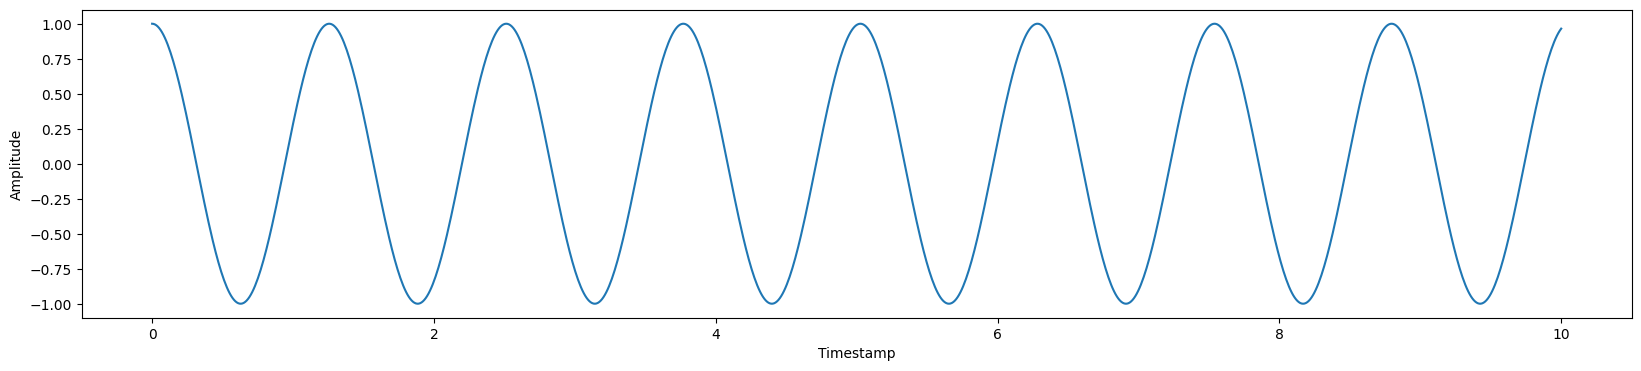

In [11]:
plt.figure(figsize=(20, 4))
plt.plot(x_periodic, y_periodic)
plt.xlabel("Timestamp")
plt.ylabel("Amplitude")
plt.show()

In [12]:
#parameters for creating Takens embeddings of periodic time series data using a sliding window approach. 
#This will be used in later parts to create embeddings that can be fed into machine learning models.
embedding_dimension_periodic = 3
embedding_time_delay_periodic = 8
stride = 10
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

In [13]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
y_periodic_embedded.shape

(99, 3)

In [14]:
plot_point_cloud(y_periodic_embedded)

In [15]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

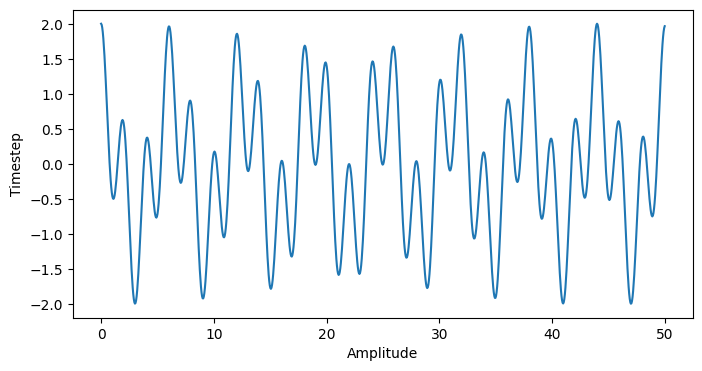

In [16]:
#Non-Periodic data ex. 
plt.figure(figsize=(8, 4))
plt.plot(x_nonperiodic, y_nonperiodic)
plt.xlabel("Amplitude")
plt.ylabel("Timestep")
plt.show()

In [17]:
#Similar to chunks above however with non-periodic data

embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

In [18]:
y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y_nonperiodic)
y_nonperiodic_embedded.shape

(323, 3)

In [19]:
plot_point_cloud(y_nonperiodic_embedded)

In [20]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]
y_periodic_embedded.shape, y_nonperiodic_embedded.shape

((1, 99, 3), (1, 323, 3))

In [21]:
homology_dimensions = [0, 1, 2] #component, loop and void
periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6) 
#using tda summary to create simplical complex system
periodic_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)

In [22]:
nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
nonperiodic_persistence_diagrams = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)

In [23]:
plot_diagram(periodic_persistence_diagrams[0])

In [24]:
plot_diagram(nonperiodic_persistence_diagrams[0])

In [25]:
DATA = Path("../data")
download_dataset('gravitational-wave-signals.npy')

Download of gravitational-wave-signals.npy dataset complete.


In [26]:
R = 0.65
n_signals = 1000

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 1000
Number of timesteps per series: 8692


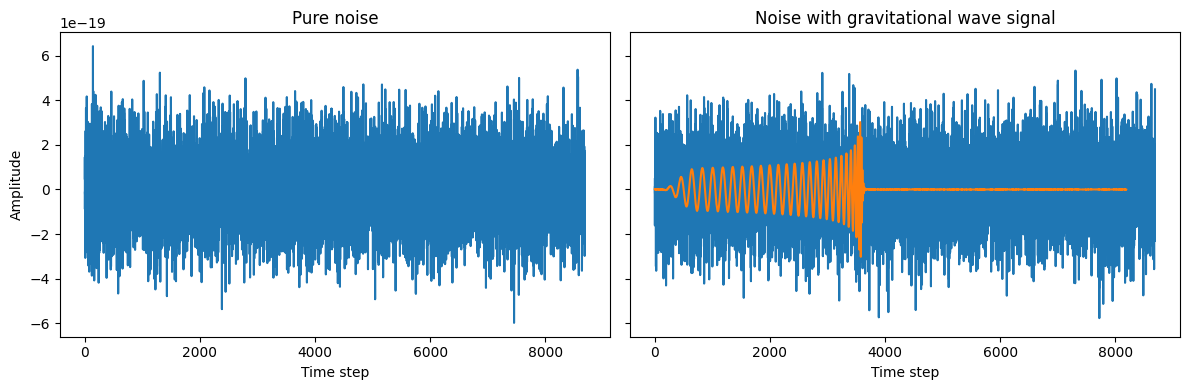

In [27]:
background_idx = np.argmin(labels)
signal_idx = np.argmax(labels)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax0.plot(noisy_signals[background_idx])
ax0.set_ylabel("Amplitude")
ax0.set_xlabel("Time step")
ax0.set_title("Pure noise")

ax1.plot(noisy_signals[1])
ax1.plot(gw_signals[signal_idx])
ax1.set_xlabel("Time step")
ax1.set_title("Noise with gravitational wave signal")

plt.tight_layout()

In [28]:
def fit_embedder(embedder, y, verbose=True):
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

In [29]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = fit_embedder(embedder, gw_signals[0])

Shape of embedded time series: (1529, 20)
Optimal embedding dimension is 20 and time delay is 29


In [30]:
pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

In [31]:
homology_dimensions = [0, 1, 2]
y_gw_embedded_pca = y_periodic_embedded[None, :, :]
y_gw_embedded_pca.shape
y_gw_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
y_gw_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)
plot_diagram(y_gw_persistence_diagrams[0])

In [32]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = fit_embedder(embedder, noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Shape of embedded time series: (1723, 6)
Optimal embedding dimension is 6 and time delay is 16


In [33]:
embedding_dimension = 200
embedding_time_delay = 10
stride = 10

point_clouds = []

for i in progress_bar(range(len(noisy_signals))):

    embedder = SingleTakensEmbedding(
        parameters_type="fixed", n_jobs=8, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )

    pca = PCA(n_components=3)
    point_clouds.append(pca.fit_transform(fit_embedder(embedder, noisy_signals[i], verbose=False)))

point_clouds = np.asarray(point_clouds)
point_clouds.shape

(1000, 671, 3)

In [40]:
homology_dimensions = [0, 1]

steps = [
    ("persistence", VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)),
    ("scaling", Scaler()),
    ("entropy", PersistenceEntropy()),
]

topological_transfomer = Pipeline(steps)

In [42]:
X = topological_transfomer.fit_transform(point_clouds)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.1, random_state=42)

In [44]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(y_train, fitted_model.predict_proba(X_train)[:, 1]),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(y_valid, fitted_model.predict_proba(X_valid)[:, 1]),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [43]:
#
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print_scores(rf)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.58
ROC AUC on valid: 0.664


In [39]:
plot_roc_curve(rf, X_valid, y_valid)
plt.show()

NameError: ignored